In [1]:
import geopandas as gp
import geodatasets
from plotnine import (
    ggplot,
    aes,
    coord_fixed,
    facet_wrap,
    geom_map,
    geom_text,
    labs,
    scale_fill_brewer,
    scale_fill_continuous,
    scale_x_continuous,
    scale_y_continuous,
    scale_size_continuous,
    stage,
    coord_cartesian,
    element_line,
    element_rect,
    element_text,
    theme_void,
    theme,
)

Define some useful functions

In [2]:
def good_centroid(geometry):
    """
    Calculate "good" centroids for polygons in the geometry

    The polygon is projected onto the Equal Area Cylindrical projection,
    the centroids are computed, then mapped back onto the original
    coordinate system.
    """
    return geometry.to_crs("+proj=cea").centroid.to_crs(geometry.crs)


def overlay_color(rgb_hex_colors, light="white", dark="black", threshold=0.5):
    """
    Decide which color is suitable to write onto the given colors
    """
    def luminance(rgb_hex):
        """
        Calculate the Luminance ([0, 1]) of a hex color
        """
        r = int(rgb_hex[1:3], 16)
        g = int(rgb_hex[3:5], 16)
        b = int(rgb_hex[5:], 16)
        luma = (r*0.299 + g*0.587 + b*0.0722) / 256
        return luma
    return [light if luminance(x) < threshold  else dark for x in rgb_hex_colors]

### A Map from `geodatasets`

We are going to use a dataset from the [geodatasets](https://geodatasets.readthedocs.io/en/latest/) package.
We can explore the dataset providers at `geodatasets.data`, each of which has one or more datasets:

We choose the dataset of Sudden Infant Death (SIDS) counts from counties in North Carolina. We can see some meta information about that dataset. You can view the details with `geodatasets.data.geoda.sids`.

Download the dataset we want (it is automatically cached).

In [3]:
geodatasets.fetch("geoda sids")

Read data

In [4]:
sids = gp.read_file(geodatasets.get_path("geoda.sids"))
sids.head()

,AREA,PERIMETER,CNTY_,CNTY_ID,NAME,FIPS,FIPSNO,CRESS_ID,BIR74,SID74,NWBIR74,BIR79,SID79,NWBIR79,geometry
0,0.114,1.442,1825,1825,Ashe,37009,37009,5,1091.0,1.0,10.0,1364.0,0.0,19.0,"POLYGON ((-81.47276 36.23436, -81.54084 36.272..."
1,0.061,1.231,1827,1827,Alleghany,37005,37005,3,487.0,0.0,10.0,542.0,3.0,12.0,"POLYGON ((-81.23989 36.36536, -81.24069 36.379..."
2,0.143,1.630,1828,1828,Surry,37171,37171,86,3188.0,5.0,208.0,3616.0,6.0,260.0,"POLYGON ((-80.45634 36.24256, -80.47639 36.254..."
3,0.070,2.968,1831,1831,Currituck,37053,37053,27,508.0,1.0,123.0,830.0,2.0,145.0,"MULTIPOLYGON (((-76.00897 36.3196, -76.01735 3..."
4,0.153,2.206,1832,1832,Northampton,37131,37131,66,1421.0,9.0,1066.0,1606.0,3.0,1197.0,"POLYGON ((-77.21767 36.24098, -77.23461 36.214..."


The `sids` data has two periods `1974 - 1978` and `1979 - 1985`. For each period there is a number of births and a number of deaths. We want to visually compare the deaths per 1000 in each county for the two periods.

In [5]:
data = sids.copy()

# Calculate the death per 1000
data["1974 - 1978"] = (data["SID74"] / data["BIR74"]) * 1000
data["1979 - 1984"] = (data["SID79"] / data["BIR79"]) * 1000

# Calculate center coordinates for the counties
data["center_lon"] = good_centroid(data.geometry).x
data["center_lat"] = good_centroid(data.geometry).y

# Make the data
data = data.melt(
    id_vars=["NAME", "geometry", "center_lon", "center_lat"],
    value_vars=["1974 - 1978", "1979 - 1984"],
    var_name="period",
    value_name="deaths_per_1k",
).rename(
    {"NAME": "county"},
    axis=1
)

data.head()

,county,geometry,center_lon,center_lat,period,deaths_per_1k
0,Ashe,"POLYGON ((-81.47276 36.23436, -81.54084 36.272...",-81.498245,36.431263,1974 - 1978,0.916590
1,Alleghany,"POLYGON ((-81.23989 36.36536, -81.24069 36.379...",-81.125138,36.490963,1974 - 1978,0.000000
2,Surry,"POLYGON ((-80.45634 36.24256, -80.47639 36.254...",-80.685736,36.412381,1974 - 1978,1.568381
3,Currituck,"MULTIPOLYGON (((-76.00897 36.3196, -76.01735 3...",-76.027392,36.407026,1974 - 1978,1.968504
4,Northampton,"POLYGON ((-77.21767 36.24098, -77.23461 36.214...",-77.410484,36.422110,1974 - 1978,6.333568


Plot the data

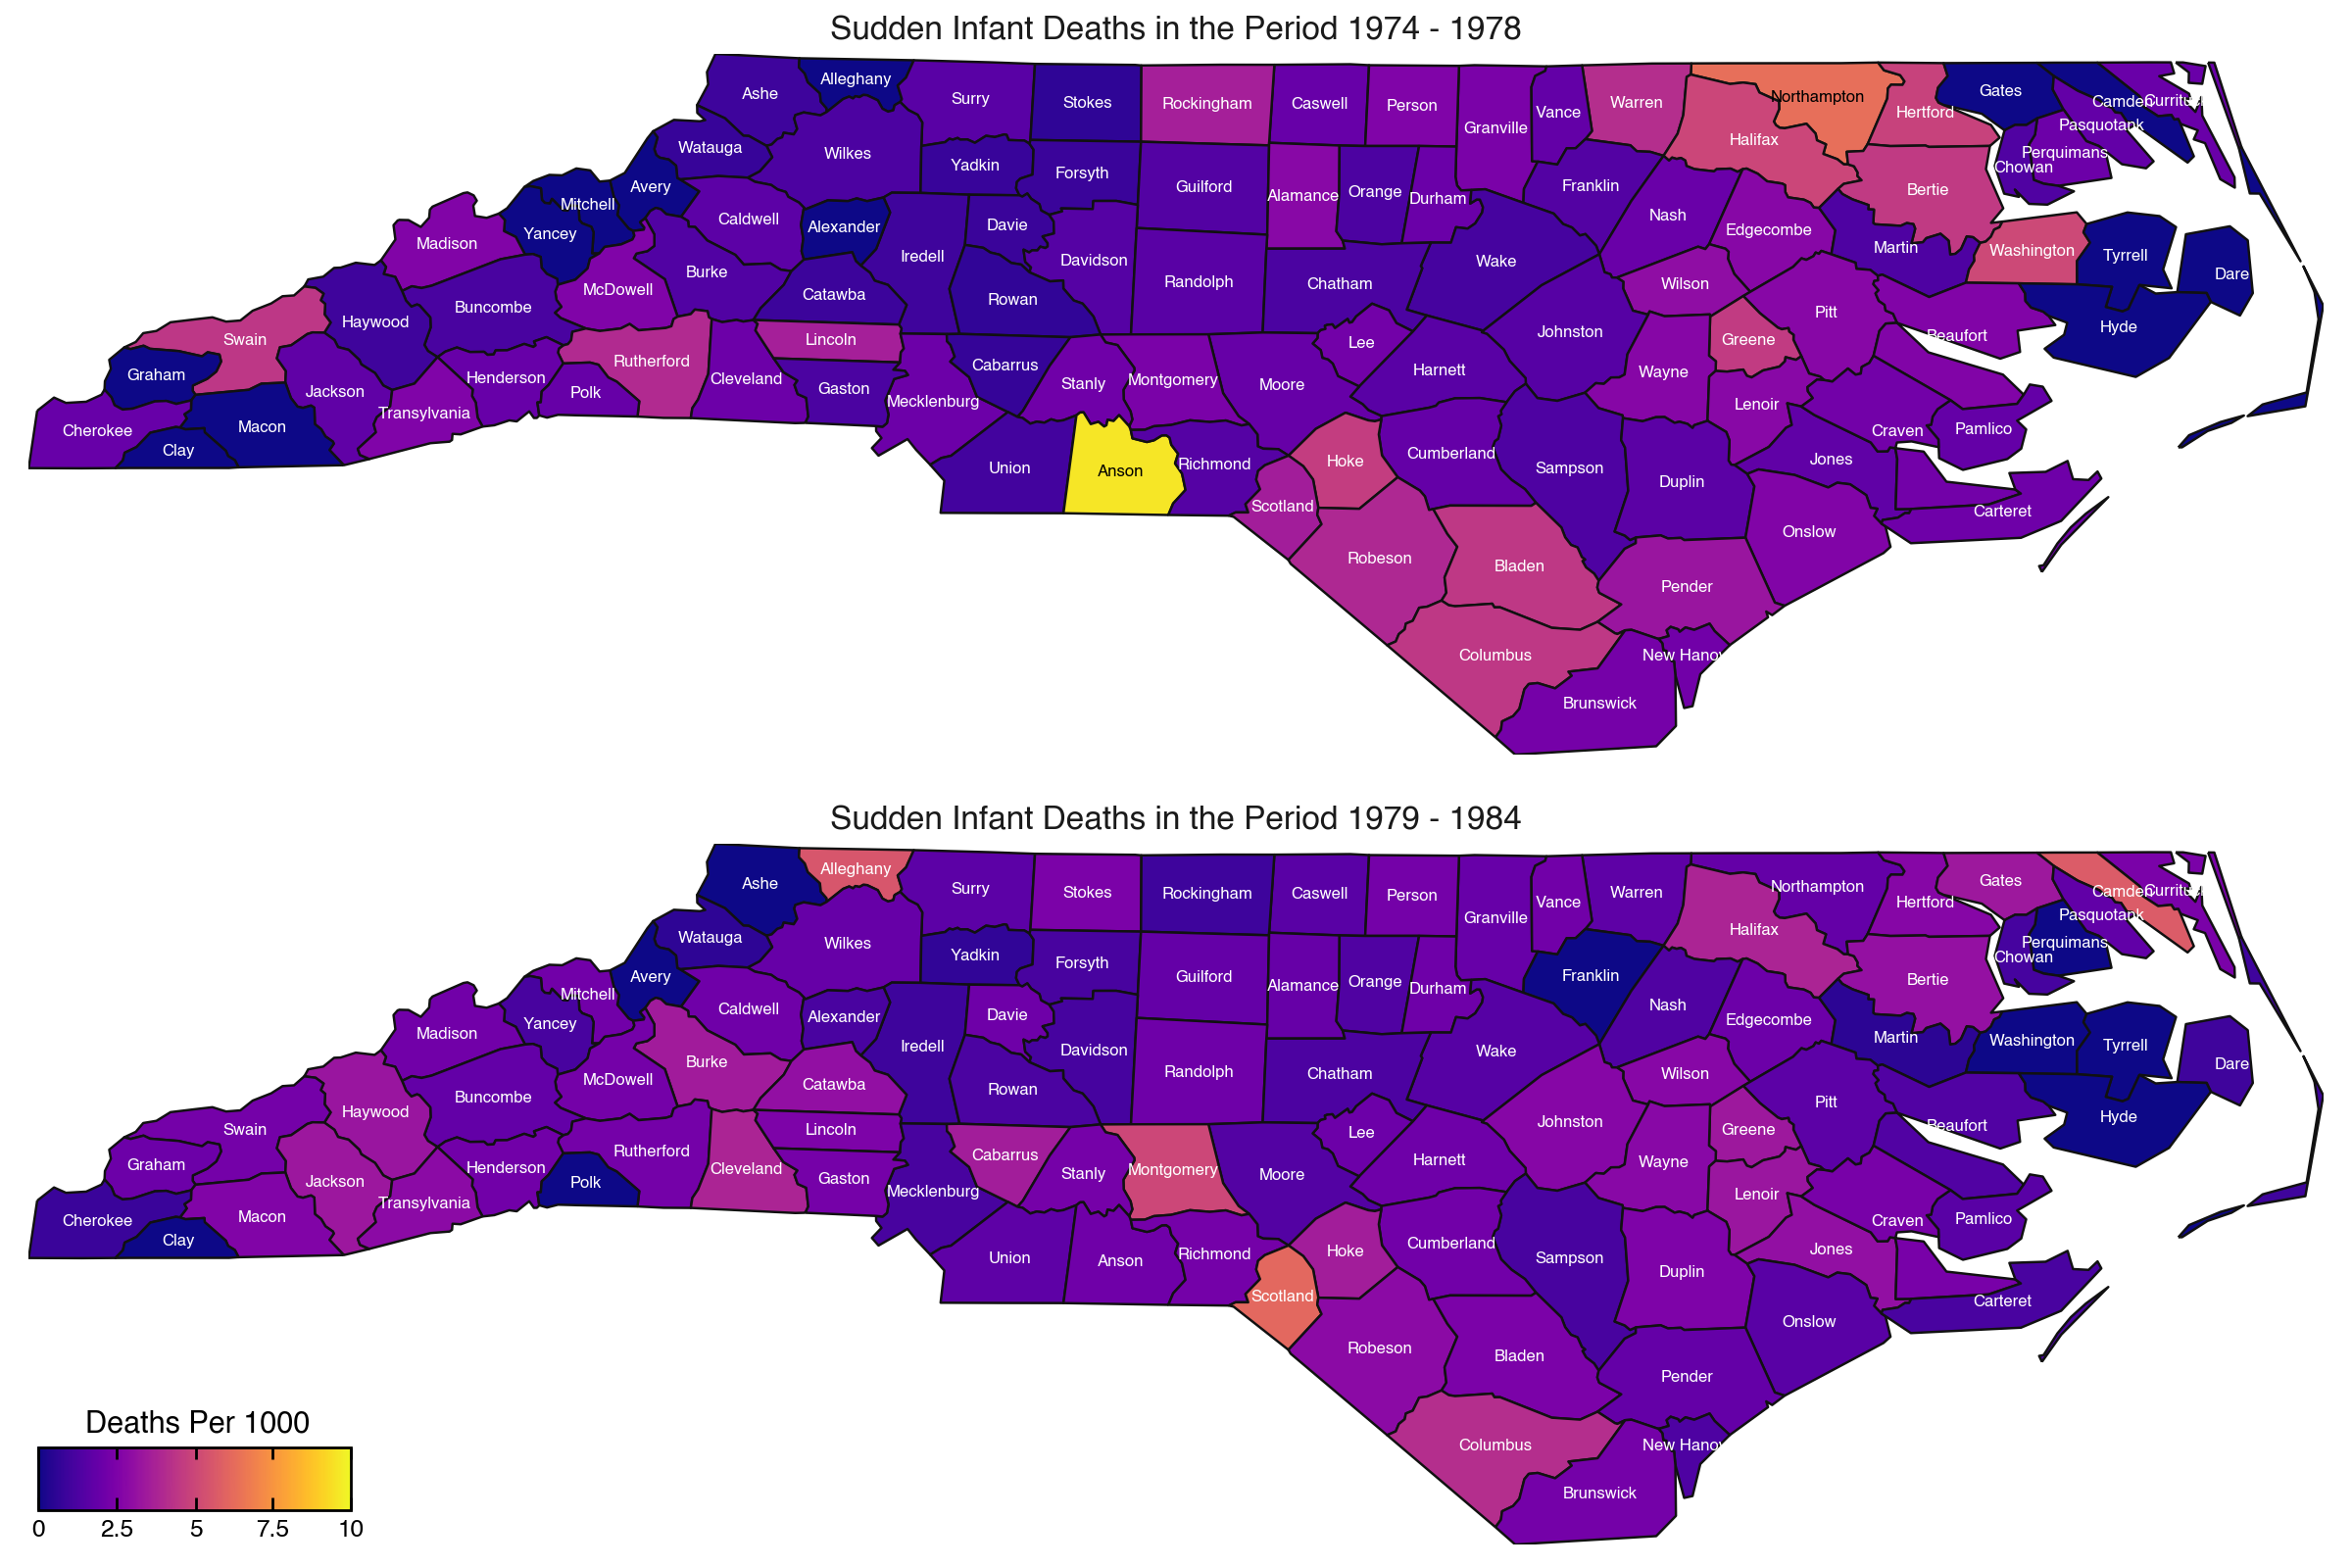

In [6]:
# Gallery, maps

(
    ggplot(data)
    + geom_map(aes(fill="deaths_per_1k"))
    + geom_text(
        aes(
            "center_lon",
            "center_lat",
            label="county",
            color=stage("deaths_per_1k", after_scale="overlay_color(color)")
        ),
        size=6,
        show_legend=False
    )
    + scale_fill_continuous(
        name="Deaths Per 1000",
        cmap_name="plasma",
        breaks=[0, 2.5, 5, 7.5, 10],
        labels=["0", "2.5", "5", "7.5", "10"],
        limits=[0, 10],
    )
    + facet_wrap(
        "period",
        ncol=1,
        labeller=lambda s: f"Sudden Infant Deaths in the Period {s}"
    )
    + coord_fixed(expand=False)
    + theme_void()
    + theme(
        figure_size=(12, 8),
        legend_position=(0, 0),
        legend_direction="horizontal",
        legend_title_position="top",
        plot_margin=0.01,
        plot_background=element_rect(fill="white"),
        panel_spacing=0.025,
        legend_frame=element_rect(color="black"),
        legend_ticks=element_line(color="black"),
        strip_text=element_text(size=12),
    )
)

### The Territories of Westeros

*Layering different features on a Map*

Read data and select features in Westeros only.

In [7]:
continents = gp.read_file("data/lands-of-ice-and-fire/continents.shp")
islands = gp.read_file("data/lands-of-ice-and-fire/islands.shp")
lakes = gp.read_file("data/lands-of-ice-and-fire/lakes.shp")
rivers = gp.read_file("data/lands-of-ice-and-fire/rivers.shp")
political = gp.read_file("data/lands-of-ice-and-fire/political.shp")
wall = gp.read_file("data/lands-of-ice-and-fire/wall.shp")
roads = gp.read_file("data/lands-of-ice-and-fire/roads.shp")
locations = gp.read_file("data/lands-of-ice-and-fire/locations.shp")

westeros = continents.query('name=="Westeros"')
islands = islands.query('continent=="Westeros" and name!="Summer Islands"')
lakes = lakes.query('continent=="Westeros"')
rivers = rivers.query('continent=="Westeros"')
roads = roads.query('continent=="Westeros"')

wg = westeros.geometry[0]
bool_idx = [wg.contains(g) for g in locations.geometry]
westeros_locations = locations[bool_idx]
cities = westeros_locations[westeros_locations["type"] == "City"].copy()

Create map by placing the features in layers in an order that limits obstraction.

The `GeoDataFrame.geometry.centroid` property has the center coordinates of polygons,
we use these to place the labels of the political regions.

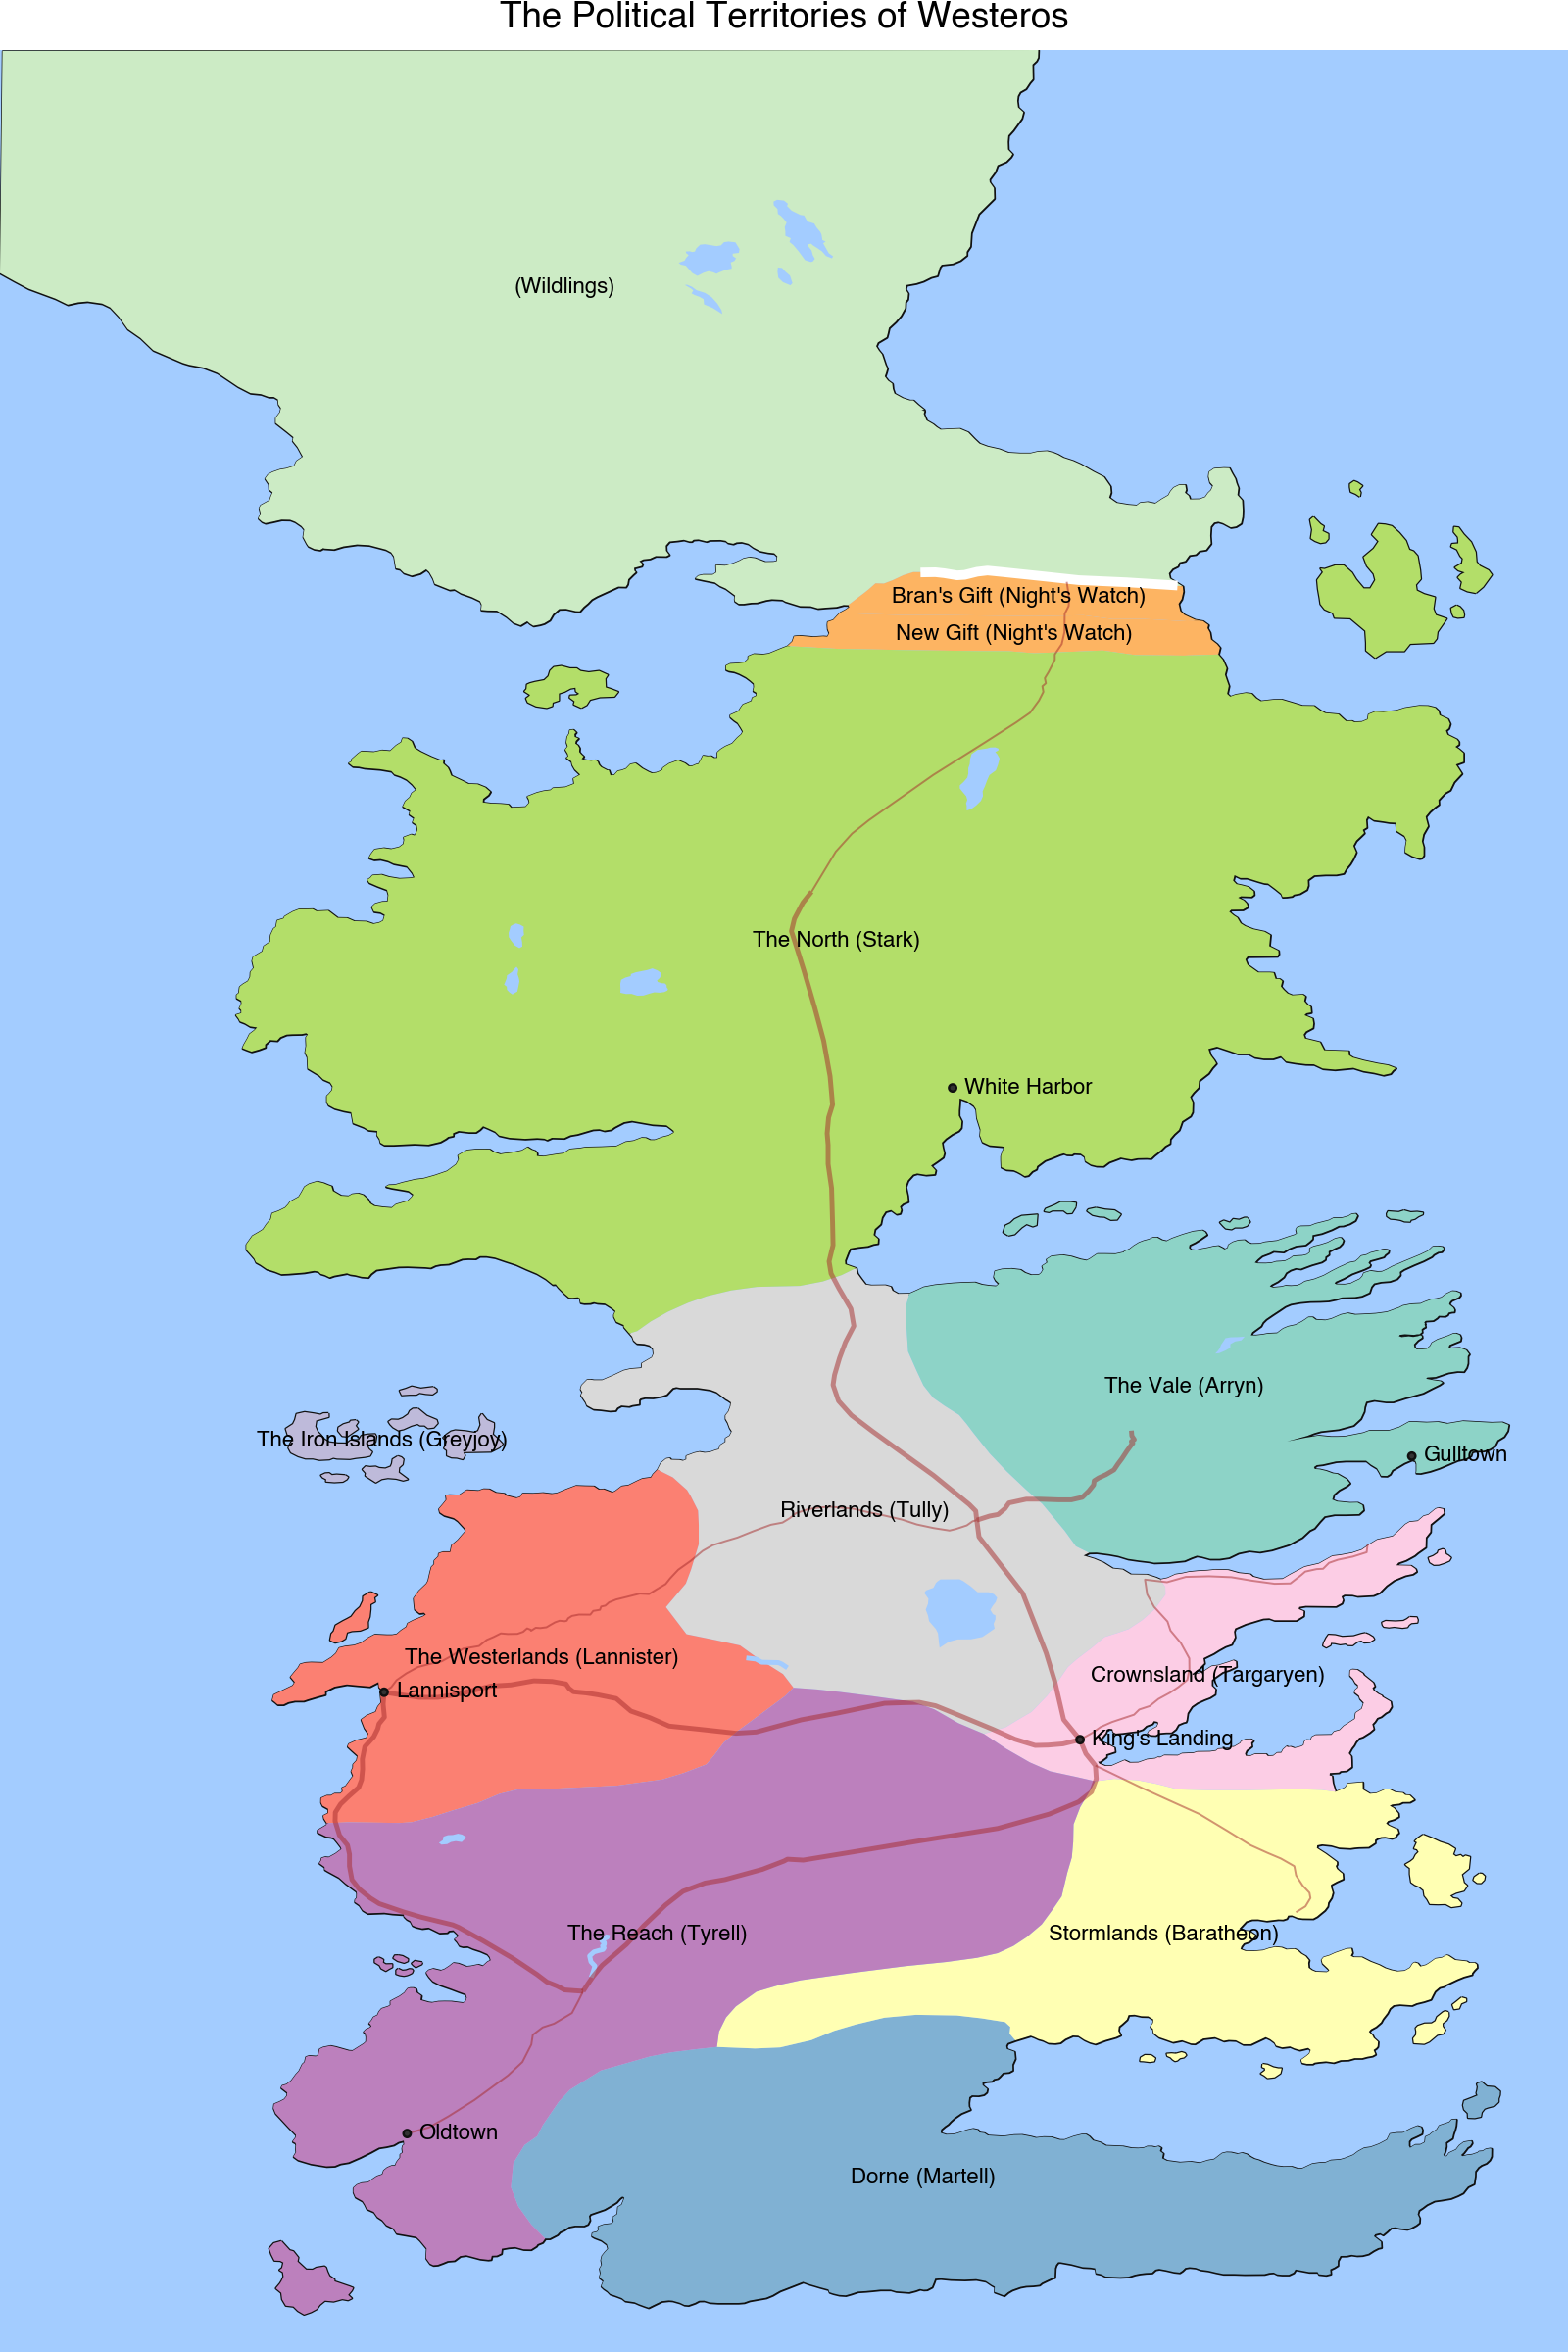

In [8]:
# Gallery, maps

# colors
water_color = "#a3ccff"
wall_color = "white"
road_color = "brown"


# Create label text by merging the territory name and
# the claimant to the territory
def fmt_labels(names, claimants):
    labels = []
    for name, claimant in zip(names, claimants):
        if name:
            labels.append("{} ({})".format(name, claimant))
        else:
            labels.append("({})".format(claimant))
    return labels


def calculate_center(df):
    """
    Calculate the centre of a geometry

    This method first converts to a planar crs, gets the centroid
    then converts back to the original crs. This gives a more
    accurate
    """
    original_crs = df.crs
    planar_crs = "EPSG:3857"
    return df["geometry"].to_crs(planar_crs).centroid.to_crs(original_crs)


political["center"] = calculate_center(political)
cities["center"] = calculate_center(cities)

(
    ggplot()
    + geom_map(westeros, fill=None)
    + geom_map(islands, fill=None)
    + geom_map(political, aes(fill="ClaimedBy"), color=None, show_legend=False)
    + geom_map(wall, color=wall_color, size=2)
    + geom_map(lakes, fill=water_color, color=None)
    + geom_map(rivers, aes(size="size"), color=water_color, show_legend=False)
    + geom_map(roads, aes(size="size"), color=road_color, alpha=0.5, show_legend=False)
    + geom_map(cities, size=1)
    + geom_text(
        political,
        aes("center.x", "center.y", label="fmt_labels(name, ClaimedBy)"),
        size=8,
        fontweight="bold",
    )
    + geom_text(
        cities,
        aes("center.x", "center.y", label="name"),
        size=8,
        ha="left",
        nudge_x=0.20,
    )
    + labs(title="The Political Territories of Westeros")
    + scale_fill_brewer(type="qual", palette=8)
    + scale_x_continuous(expand=(0, 0, 0, 1))
    + scale_y_continuous(expand=(0, 1, 0, 0))
    + scale_size_continuous(range=(0.4, 1))
    + coord_cartesian()
    + theme_void()
    + theme(figure_size=(8, 12), panel_background=element_rect(fill=water_color))
)

**Credit**: [cadaei](https://www.cartographersguild.com/member.php?u=95244) of the [cartographersguild](https://www.cartographersguild.com/) website forum.